In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib
from collections import Counter
import matplotlib.pyplot as plt

# 读取用户上传的文件
file_path = 'current_feature_best_slope_multiplier.csv'
df = pd.read_csv(file_path)

# 假设第一列是特征，后一列是目标
X = df[['k']]
y = df['ttf']

# 定义超参数调优范围
param_grid = {
    'n_estimators': [30,40,50, 100, 200, 300],
 
    'max_depth': [3, 4, 5]
    
}

# 进行多次随机采样并在每次随机采样中进行交叉验证
n_iterations = 1  # 设定你希望进行的随机采样次数
best_params_list = []

for i in range(n_iterations):
    # 每次随机采样不同的训练和测试集
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # 定义随机森林回归模型
    rf = RandomForestRegressor(random_state=42)
    
    # 使用交叉验证进行超参数调优
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=4, verbose=2)
    grid_search.fit(X_train_sample, y_train_sample)
    
    # 获取最佳超参数
    best_params_list.append(tuple(grid_search.best_params_.items()))

# 统计最佳超参数的出现频率
params_counter = Counter(best_params_list)
most_common_params = params_counter.most_common(5)

# 创建DataFrame保存超参数及其出现次数
params_df = pd.DataFrame(most_common_params, columns=['Params', 'Frequency'])

# 将超参数记录保存到Excel文件中
excel_file_path = 'best_params_frequency.xlsx'
params_df.to_excel(excel_file_path, index=False)

# 选择出现频率最高的超参数
best_params_mode = dict(most_common_params[0][0])

# 使用整个数据集训练最终模型并保存
best_rf = RandomForestRegressor(random_state=42, **best_params_mode)
best_rf.fit(X, y)

# 保存最终的最佳模型
model_file_path = 'best_random_forest_model.pkl'
joblib.dump(best_rf, model_file_path)




Fitting 5 folds for each of 18 candidates, totalling 90 fits


['best_random_forest_model.pkl']

Mean R² over multiple iterations: 0.9645548822313826
Mean RMSE over multiple iterations: 23.548262945552878


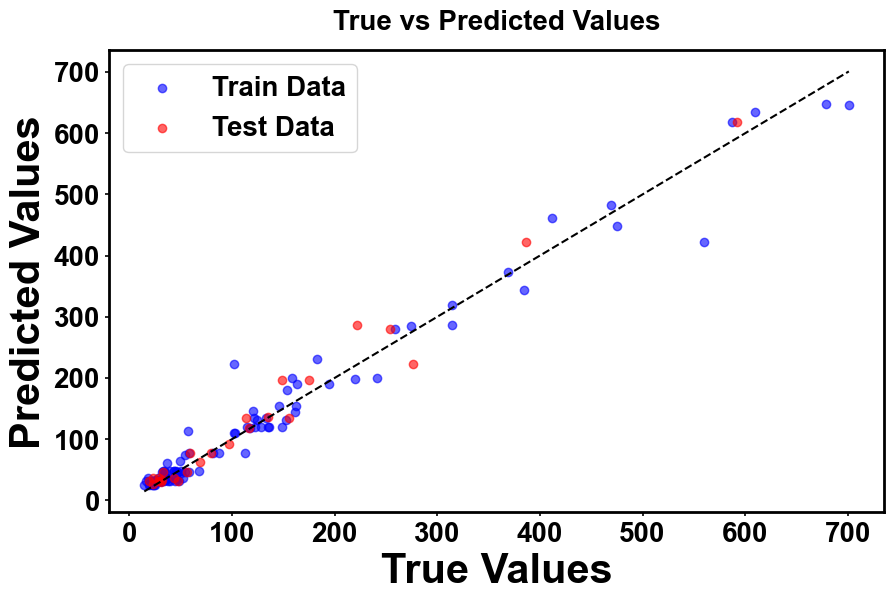

In [36]:
# 多次采样进行最终模型评估
r2_scores = []
rmse_scores = []

for i in range(100):
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X, y, test_size=0.2, random_state=i)
    y_pred = best_rf.predict(X_test_sample)
    
    r2_scores.append(r2_score(y_test_sample, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_sample, y_pred)))

# 计算平均R²和RMSE
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
print("Mean R² over multiple iterations:", mean_r2)
print("Mean RMSE over multiple iterations:", mean_rmse)

# 使用最佳模型进行预测
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# 在训练集上的真实值和预测值对比
train_results = pd.DataFrame({
    'True Values': y_train,
    'Predicted Values': y_train_pred,
    'Data Split': 'Train'
})

# 在测试集上的真实值和预测值对比
test_results = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_test_pred,
    'Data Split': 'Test'
})

# 合并训练集和测试集的结果
all_results = pd.concat([train_results, test_results])

# 保存结果到Excel文件
results_excel_file_path = 'prediction_results.xlsx'
all_results.to_excel(results_excel_file_path, index=False)

# 画散点图
# 设置全局字体为Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'  # 设置全局字体为加粗
plt.figure(figsize=(10, 6))
plt.scatter(train_results['True Values'], train_results['Predicted Values'], color='blue', label='Train Data', alpha=0.6)
plt.scatter(test_results['True Values'], test_results['Predicted Values'], color='red', label='Test Data', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='black', linestyle='--')
plt.xlabel('True Values',fontsize=30, fontweight='bold')
plt.ylabel('Predicted Values', fontsize=30, fontweight='bold')
plt.legend(fontsize=20)
plt.title('True vs Predicted Values', fontsize=20, fontweight='bold', pad=15)
# 设置刻度值的字号
plt.xticks(fontsize=20)  # 设置x轴刻度值的字号
plt.yticks(fontsize=20)  # 设置y轴刻度值的字号
# 调节轴的刻度线（齿）的粗细
plt.gca().tick_params(axis='both', width=1.2)  # 轴刻度线的宽度
plt.gca().tick_params(axis='both', length=3)  # 轴刻度线的长度
# 调节图框粗细
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()